In [441]:
import os
os.environ["MKL_SERVICE_FORCE_INTEL"] = "1"
import numpy as np
from astropy.table import Table, vstack
from matplotlib import pyplot as plt
%matplotlib inline
import re
homedir=os.getenv('HOME')

### Developing the architecture

In [2]:
#load phot table, vf table
#convert phot fluxes from nanomaggies to mJy --> multiply by 3.631e-3
#if no flux entry, replace with NaN
#header format must follow the following setup:
# id redshift filter1 filter1_err filter2 filter2_err filter3 filter3_err ...
#I *think* I will generate two input files? One for DEC>+32, one for DEC<+32 (will have different grz filters)
#for pcigale.ini (after pcigale genconf), may either have to MANUALLY edit file *or* try some automatic
# approach based on user-set parameters

#regarding the output files...
    #create empty table, same length as vf
    #add all VFIDs as first column
    #for every ID in output file, find correct row element and insert the desired parameters
    #CONVERT SFR, Mstar to log10!

In [48]:
#now that I have the main architecture, I will demonstrate the functionality of the .py files
#all column names are currently tailored to the VFS photometry catalog. subject to change.

---

### Evaluating Results

In [829]:
fulltab = Table.read(homedir+'/Desktop/cigale_vf/results_negflux.fits')

In [830]:
magphys=Table.read(homedir+'/Desktop/galfit_files/vf-altphot.fits')

In [831]:
comtab=[]
for i in range(len(magphys)):
    if magphys['VFID'][i] in fulltab['id']:
        comtab.append(True)
    else:
        comtab.append(False)
magphys = magphys[comtab]

In [832]:
#various photometry flags from John's catalog

sat_flag = (~magphys['unsaturated_flag'])
medium_flag = (~magphys['nomedstar_flag'])
wisestar_flag = (~magphys['nowisestar_flag'])
bad_phot_flag = (~magphys['good_phot_flag'])

phot_flags = sat_flag | medium_flag | wisestar_flag | bad_phot_flag

#good_phot_flag --> Vcosmic>0 AND AP06 flux > 0 in every band
#unsaturated_flag --> grz bands are NOT saturated
#nomedstar_flag --> no medium star
#nowisestar_flag --> no WISE star

In [833]:
magphys_cut = magphys[phot_flags]
cigale_cut = fulltab[phot_flags]

In [834]:
magphys_mass = magphys_cut['MAGPHYS_logMstar_med']
magphys_sfr = magphys_cut['MAGPHYS_logSFR_med']
cigale_mass = np.log10(cigale_cut['bayes.stellar.m_star'])
cigale_sfr = np.log10(cigale_cut['bayes.sfh.sfr'])

/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_76660/1278783632.py:3: RuntimeWarning: invalid value encountered in log10
  cigale_mass = np.log10(cigale_cut['bayes.stellar.m_star'])
/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_76660/1278783632.py:4: RuntimeWarning: invalid value encountered in log10
  cigale_sfr = np.log10(cigale_cut['bayes.sfh.sfr'])


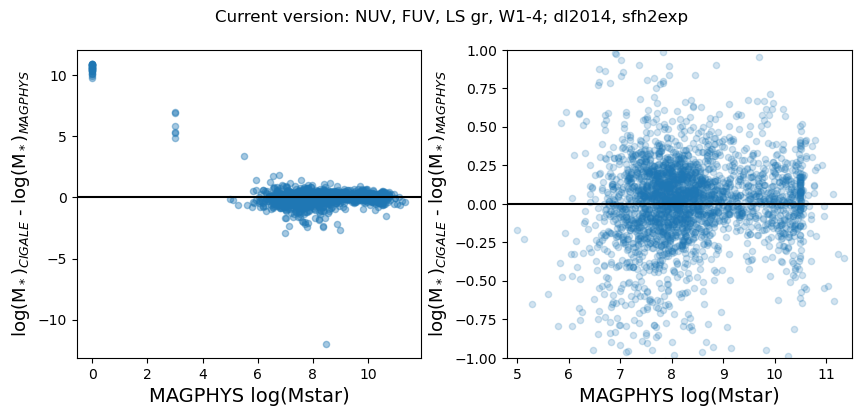

0.03009115949758545


In [863]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
plt.subplots_adjust(wspace=0.25)
ax1.scatter(magphys_mass, cigale_mass - magphys_mass,s=20,alpha=0.4)
ax1.axhline(0,color='black')
ax2.scatter(magphys_mass,cigale_mass - magphys_mass,s=20,alpha=0.2)
ax2.axhline(0,color='black')
ax2.set_xlim(4.8,11.5)
ax2.set_ylim(-1,1)
#ax2.set_ylim(-5,5)

ax1.set_xlabel('MAGPHYS log(Mstar)',fontsize=14)
ax1.set_ylabel(r'log(M$_*$)$_{CIGALE}$ - log(M$_*$)$_{MAGPHYS}$',fontsize=13)
ax2.set_xlabel('MAGPHYS log(Mstar)',fontsize=14)
ax2.set_ylabel(r'log(M$_*$)$_{CIGALE}$ - log(M$_*$)$_{MAGPHYS}$',fontsize=13)

plt.suptitle("Current version: NUV, FUV, LS gr, W1-4; dl2014, sfh2exp", fontsize=12)
plt.show()

print(np.median(cigale_mass[~np.isnan(cigale_mass)]-magphys_mass[~np.isnan(cigale_mass)]))

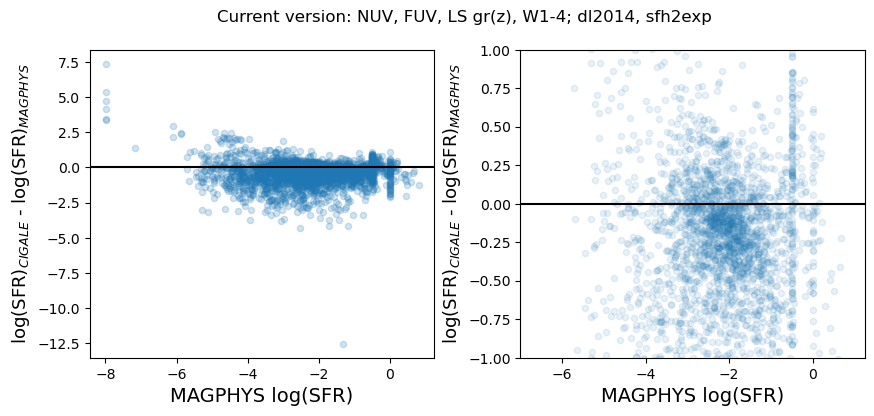

-0.25796753802032857


In [836]:
#flag = (magphys['MAGPHYS_logSFR_med'][comtab] > -7) & (magphys['MAGPHYS_logSFR_med'][comtab] < -0.6)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
plt.subplots_adjust(wspace=0.25)
ax1.scatter(magphys_sfr, cigale_sfr - magphys_sfr,s=20,alpha=0.2)
ax1.axhline(0,color='black')
ax2.scatter(magphys_sfr, cigale_sfr - magphys_sfr,s=20,alpha=0.1)
ax2.axhline(0,color='black')
ax2.set_xlim(-7,)
ax2.set_ylim(-1,1)

ax1.set_xlabel('MAGPHYS log(SFR)',fontsize=14)
ax1.set_ylabel(r'log(SFR)$_{CIGALE}$ - log(SFR)$_{MAGPHYS}$',fontsize=13)
ax2.set_xlabel('MAGPHYS log(SFR)',fontsize=14)
ax2.set_ylabel(r'log(SFR)$_{CIGALE}$ - log(SFR)$_{MAGPHYS}$',fontsize=13)

plt.suptitle("Current version: NUV, FUV, LS gr(z), W1-4; dl2014, sfh2exp", fontsize=12)
plt.show()

print(np.median(cigale_sfr[~np.isnan(cigale_sfr)]-magphys_sfr[~np.isnan(cigale_sfr)]))

### Notes and Troubleshooting Attempts

In [13]:
#changed grz headers from 'energy' to 'photon.' numbers match original txtfiles. gives same results as when
#I keep 'energy.'

#---confirmed that generated table has correct flux information...converted from nanomaggies to mJy (*3.631e-3)
#also tried changing energy values of grz filters from Jy (I presume) to mJy...no change

#appears that best-fit models really only pass through W3 and W4 measurements...relatively high chi-squared values

#changing to SDSS g_prime, r_prime only negligibly affects results. but that is also curious, since I previously
#found a different value for VFID0005 logMstar with those SDSS filters! ~8.65. what changed? *the parameters.*
    #reverting to initial parameters...sfhdelayed and dale2014. THESE recover that logMstar = 9.36 value for VFID0005.
#however...instructed to instead use sfh2exp and dl2014. with sfhdelayed and dale2014, result is ~9.01.
#now, using the legacy survey filters with sfhdelayed and dale2014, ... again, MINIMAL difference. curious indeed.

#next test: using galex.NUV, galex.FUV --> different from NUV, FUV?
    #...negligible change. dlogMstar ~0.0001

#next next test: implementing z-band?
    #somewhat negligible change. dlogMstar ~0.01

#and now... I default to sfhdelayed, dl2014, and generate with sed plots.
#I keep the z-band values.

#CIGALE may just be the reason I develop a hernia.

In [78]:
#two remaining ideas...

#(1) compare MAGPHYS NUV, FUV textfiles with CIGALE's files
    #I can't seem to do so. MAGPHYS' filters are all embedded in the same binary file, which I cannot read.

#(2) try different combinations of parameters -- do any fit the smaller wavelength fluxes more robustly?
    
    #well...I will not bother much with this point. HOWEVER, it did engender a new thought
        
        #only 3 models generated per galaxy, then the best-fit is taken from these models. that is not a lot of models.
        #if I add more potential values to some of the parameter arguments, then the number of models rises
        #(can check by typing "pcigale check" while in the same directory as pcigale.ini)
        
        #do I need to tweak the parameters somehow to better reflect the nature of the galaxy population?
        #or maybe add multiple options (comma-separated in the relevant spots of the file)?
        
        #this is where I am currently stuck --> I have not the knowledge, really, to pursue this further.
        
        #naively, though, I assume that the generation of more physically-motivated models (rather than
        #just using default parameter values) may be a benefit here.
        
        #and...do I need to include any AGN modules? 
        
#what am I doing? :-/

#OKAY! I ADDED A FEW DIFFERENT VALUES FOR tau main (500., 2000. (default)) and 
#age_main = (100, 300, 500, 3e3, 5e3 (default?)). stellar mass results are slightly higher, so 1-to-1
#is marginally better? still unsure about correct parameters to use, but this is promising!
#(the use of "better" is predicated on the (likely) untenable assumption that MAGPHYS stellar masses are correct)

#another note...in pcigale.ini, under [analysis_params], can specify desired BAYES variables (similar to median
#model parameters in MAGPHYS table?). can do sfh.sfr, stellar.m_star

#comparing VFID0005 SED models, ... not terribly impressed.

#NOTE: when I want to permanently implement module parameter changes, I must edit the run_cigale.py file 
#(similar to how I edited the save_best_sed = True line)
#when I'm just testing, I can directly edit the pcigale.ini files, then type "pcigale run" in that directory.
#for .pdf files, in that same directory, then type pcigale-plots sed

In [228]:
#AUGUST 1, 2024 notizen.
#met with Greg; will be running CIGALE *again* with additional comma-separated parameters, which
#are not only more numerous than my juvenile initial guess, but also better motivated.
#also am now applying MW-transmission (MW == Milky Way) correction. 
    #given in vf_v2_extinction.fits (magnitudes) --> then convert to linear scale factor
    #using (10.**(ext_value[f'A({i})_SFD']/2.5)), where i is the filter name.

#ALSO --> VALUES FOR AGE_BURST *CANNOT* BE LARGER THAN THE SMALLEST VALUE FOR AGE_MAIN

#AUGUST 5, 2024 notizen
#adding additional parameters options for A_v was effective! The fits now look quite robust!
#However, the uncertainties attached to the Bayes output parameters remain a bit...large. 

---

### Tom's Herschel Sample

In [731]:
#create pcigale.ini files 
with open(homedir+'/Desktop/cigale_tom/pcigale.ini', 'w') as file:
    file.write('data_file = vf_data_south.txt \n')
    file.write('parameters_file = \n')
    file.write('sed_modules = sfh2exp, bc03, nebular, dustatt_modified_CF00, dl2014, skirtor2016, redshifting \n')
    file.write('analysis_method = pdf_analysis \n')
    file.write('cores = 3 \n')
    file.close()    

#create pcigale.ini.spec files

with open(homedir+'/Desktop/cigale_tom/pcigale.ini.spec', 'w') as file:
    file.write('data_file = string() \n')
    file.write('parameters_file = string() \n')
    file.write('sed_modules = cigale_string_list() \n')
    file.write('analysis_method = string() \n')
    file.write('cores = integer(min=1)')
    file.close()

In [810]:
nor = Table.read(homedir+'/Desktop/cigale_tom/vf_data_north.txt',format='ascii')
sou = Table.read(homedir+'/Desktop/cigale_tom/vf_data_south.txt',format='ascii')

In [811]:
nan_arr_nor = np.zeros(len(nor))
nan_arr_sou = np.zeros(len(sou))

nan_arr_nor[:] = np.nan
nan_arr_sou[:] = np.nan

nor.add_column(nan_arr_nor,index=8,name='decamDR1-g')
nor.add_column(nan_arr_nor,index=9,name='decamDR1-g_err')
nor.add_column(nan_arr_nor,index=12,name='decamDR1-r')
nor.add_column(nan_arr_nor,index=13,name='decamDR1-r_err')
nor.add_column(nan_arr_nor,index=14,name='decamDR1-z')
nor.add_column(nan_arr_nor,index=15,name='decamDR1-z_err')

In [812]:
sou.add_column(nan_arr_sou,index=6,name='BASS-g')
sou.add_column(nan_arr_sou,index=7,name='BASS-g_err')
sou.add_column(nan_arr_sou,index=10,name='BASS-r')
sou.add_column(nan_arr_sou,index=11,name='BASS-r_err')

In [813]:
comb_tab = vstack([nor,sou])

In [814]:
flux_names = ['FUV','NUV','BASS-g','decamDR1-g','BASS-r','decamDR1-r','decamDR1-z',
             'WISE1','WISE2','WISE3','WISE4','PACS_blue','PACS_green','PACS_red']
flux_13 = ['FUV','NUV','WISE1','WISE2','WISE3','WISE4','PACS_blue','PACS_green','PACS_red']

In [815]:
for flux in flux_names:
    for i in range(len(comb_tab)):
        
        if flux in flux_13:   #FUV, NUV, W*, PACS*
            if (comb_tab[f'{flux}_err'][i]/np.abs(comb_tab[flux][i])) < 0.10:
                        comb_tab[f'{flux}_err'][i] = np.abs(0.13*comb_tab[flux][i])
            else:   #legacy grz
                if (comb_tab[f'{flux}_err'][i]/np.abs(comb_tab[flux][i])) < 0.10:
                    comb_tab[f'{flux}_err'][i] = np.abs(0.10*comb_tab[flux][i])
        
        if (comb_tab[flux][i]<0.) & ~((0.<(comb_tab[flux][i]+comb_tab[f'{flux}_err'][i]*4)) & (0.>(comb_tab[flux][i]-comb_tab[f'{flux}_err'][i]*4))):
            comb_tab[flux][i] = 'NaN'
            comb_tab[f'{flux}_err'][i] = 'NaN'

In [817]:
comb_tab.write(homedir+'/Desktop/vf_tab.txt',format='ascii')

### MISC.

#### Evaluating differences between CIGALE run with negative flux values $\geq -5$ included vs. the run for which all negative values are excluded (meaning they are replaced with NaN entries).

In [556]:
d=Table.read(homedir+'/Desktop/cigale_vf/results_NS.fits')

In [557]:
neg_uv_flag = (phot['FLUX_AP06_FUV']<0.) | (phot['FLUX_AP06_NUV']<0.)
neg_grz_flag = (phot['FLUX_AP06_G']<0.) | (phot['FLUX_AP06_R']<0.) | (phot['FLUX_AP06_Z']<0.)
neg_wise_flag = (phot['FLUX_AP06_W1']<0.) | (phot['FLUX_AP06_W2']<0.) | (phot['FLUX_AP06_W3']<0.) | (phot['FLUX_AP06_W4']<0.)
neg_flux_flag = (neg_uv_flag) | (neg_grz_flag) | (neg_wise_flag)

/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_76660/402550704.py:6: RuntimeWarning: invalid value encountered in log10
  ax1.scatter(np.log10(d['bayes.sfh.sfr'][neg_uv_flag]),np.log10(fulltab['bayes.sfh.sfr'][neg_uv_flag]),
/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_76660/402550704.py:9: RuntimeWarning: invalid value encountered in log10
  ax1.scatter(np.log10(d['bayes.sfh.sfr'][neg_wise_flag]),np.log10(fulltab['bayes.sfh.sfr'][neg_wise_flag]),
/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_76660/402550704.py:15: RuntimeWarning: invalid value encountered in log10
  ax2.scatter(np.log10(d['bayes.sfh.sfr']),np.log10(fulltab['bayes.sfh.sfr'])-np.log10(d['bayes.sfh.sfr']),
/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_76660/402550704.py:18: RuntimeWarning: invalid value encountered in log10
  ax2.scatter(np.log10(d['bayes.sfh.sfr'][neg_uv_flag]),
/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_76660/402550704.py:19: RuntimeWa

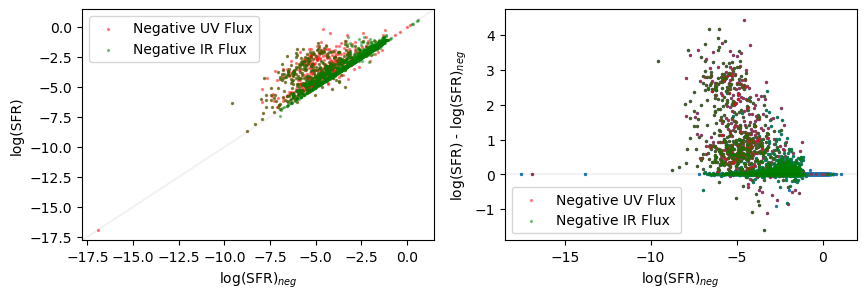

In [604]:
fig,ax=plt.subplots(1,2,figsize=(10,3))
ax1,ax2=ax.flatten()

#ax1.scatter(np.log10(d['bayes.sfh.sfr']),np.log10(fulltab['bayes.sfh.sfr']),alpha=0.3,s=2)

ax1.scatter(np.log10(d['bayes.sfh.sfr'][neg_uv_flag]),np.log10(fulltab['bayes.sfh.sfr'][neg_uv_flag]),
            s=2,color='r',label='Negative UV Flux',alpha=0.4)

ax1.scatter(np.log10(d['bayes.sfh.sfr'][neg_wise_flag]),np.log10(fulltab['bayes.sfh.sfr'][neg_wise_flag]),
            s=2,color='g',label='Negative IR Flux',alpha=0.4)


ax1.axline((0,0), slope=1,color='black',alpha=0.05)

ax2.scatter(np.log10(d['bayes.sfh.sfr']),np.log10(fulltab['bayes.sfh.sfr'])-np.log10(d['bayes.sfh.sfr']),
            alpha=1,s=2)

ax2.scatter(np.log10(d['bayes.sfh.sfr'][neg_uv_flag]),
            np.log10(fulltab['bayes.sfh.sfr'][neg_uv_flag])-np.log10(d['bayes.sfh.sfr'][neg_uv_flag]),
            s=2,color='r',label='Negative UV Flux',alpha=0.4)

ax2.scatter(np.log10(d['bayes.sfh.sfr'][neg_wise_flag]),
            np.log10(fulltab['bayes.sfh.sfr'][neg_wise_flag])-np.log10(d['bayes.sfh.sfr'][neg_wise_flag]),
            s=2,color='green',label='Negative IR Flux',alpha=0.4)

ax2.axhline(0,color='black',alpha=0.05)
ax2.set_xlabel(r'log(SFR)$_{neg}$')
ax2.set_ylabel(r'log(SFR) - log(SFR)$_{neg}$')
ax1.set_xlabel(r'log(SFR)$_{neg}$')
ax1.set_ylabel('log(SFR)')
ax1.legend()
ax2.legend()

/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_76660/1056628835.py:7: RuntimeWarning: invalid value encountered in log10
  ax1.scatter(np.log10(d['bayes.stellar.m_star'][neg_uv_flag]),np.log10(fulltab['bayes.stellar.m_star'][neg_uv_flag]),
/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_76660/1056628835.py:10: RuntimeWarning: invalid value encountered in log10
  ax1.scatter(np.log10(d['bayes.stellar.m_star'][neg_wise_flag]),np.log10(fulltab['bayes.stellar.m_star'][neg_wise_flag]),
/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_76660/1056628835.py:15: RuntimeWarning: invalid value encountered in log10
  ax2.scatter(np.log10(d['bayes.stellar.m_star']),np.log10(fulltab['bayes.stellar.m_star'])-np.log10(d['bayes.stellar.m_star']),
/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_76660/1056628835.py:18: RuntimeWarning: invalid value encountered in log10
  ax2.scatter(np.log10(d['bayes.stellar.m_star'][neg_uv_flag]),
/var/folders/gx/q5wqxlgs0rgfm6

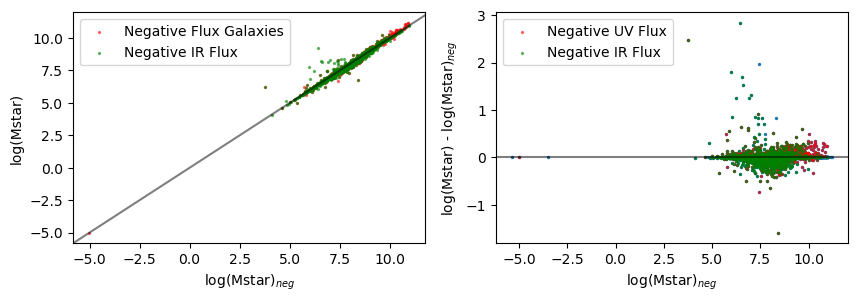

In [581]:
fig,ax=plt.subplots(1,2,figsize=(10,3))
ax1,ax2=ax.flatten()


#ax1.scatter(np.log10(d['bayes.stellar.m_star']),np.log10(fulltab['bayes.stellar.m_star']),alpha=0.3,s=2)

ax1.scatter(np.log10(d['bayes.stellar.m_star'][neg_uv_flag]),np.log10(fulltab['bayes.stellar.m_star'][neg_uv_flag]),
            s=2,color='r',label='Negative Flux Galaxies',alpha=0.5)

ax1.scatter(np.log10(d['bayes.stellar.m_star'][neg_wise_flag]),np.log10(fulltab['bayes.stellar.m_star'][neg_wise_flag]),
            s=2,color='g',label='Negative IR Flux',alpha=0.5)

ax1.axline((0,0), slope=1,color='black',alpha=0.5)

ax2.scatter(np.log10(d['bayes.stellar.m_star']),np.log10(fulltab['bayes.stellar.m_star'])-np.log10(d['bayes.stellar.m_star']),
            alpha=1,s=2)

ax2.scatter(np.log10(d['bayes.stellar.m_star'][neg_uv_flag]),
            np.log10(fulltab['bayes.stellar.m_star'][neg_uv_flag])-np.log10(d['bayes.stellar.m_star'][neg_uv_flag]),
            s=2,color='r',label='Negative UV Flux',alpha=0.5)

ax2.scatter(np.log10(d['bayes.stellar.m_star'][neg_wise_flag]),
            np.log10(fulltab['bayes.stellar.m_star'][neg_wise_flag])-np.log10(d['bayes.stellar.m_star'][neg_wise_flag]),
            s=2,color='g',label='Negative IR Flux',alpha=0.5)

ax2.axhline(0,color='black',alpha=0.5)
ax2.set_xlabel(r'log(Mstar)$_{neg}$')
ax2.set_ylabel(r'log(Mstar) - log(Mstar)$_{neg}$')
ax1.set_xlabel(r'log(Mstar)$_{neg}$')
ax1.set_ylabel('log(Mstar)')
ax1.legend()
ax2.legend()

Text(0, 0.5, '$\\chi^2_{red}$')

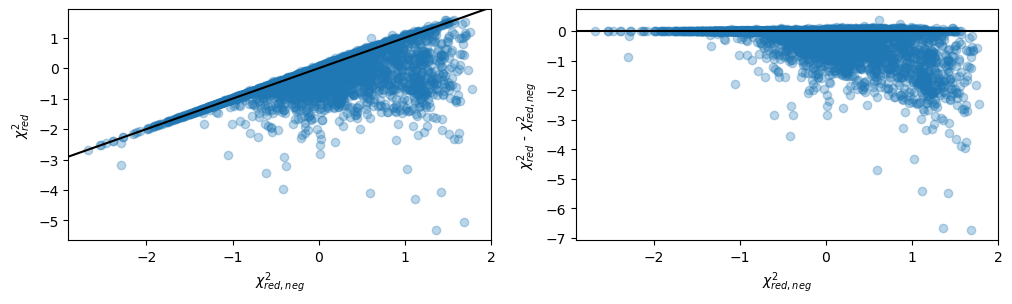

In [560]:
fig,ax=plt.subplots(1,2,figsize=(12,3))
ax1,ax2=ax.flatten()
ax1.scatter(np.log10(d['best.reduced_chi_square']),np.log10(fulltab['best.reduced_chi_square']),alpha=0.3)
ax1.axline((0,0), slope=1,color='black')
ax2.scatter(np.log10(d['best.reduced_chi_square']),np.log10(fulltab['best.reduced_chi_square'])-np.log10(d['best.reduced_chi_square']),alpha=0.3)
ax2.axhline(0,color='black')
ax2.set_xlabel(r'$\chi^2_{red, neg}$')
ax2.set_ylabel(r'$\chi^2_{red}$ - $\chi^2_{red, neg}$')
ax1.set_xlabel(r'$\chi^2_{red, neg}$')
ax1.set_ylabel('$\chi^2_{red}$')

#### Number of galaxies with negative flux values, per wavelength band

In [540]:
print('FUV',len(phot[phot['FLUX_AP06_FUV']<0.]))
print('NUV',len(phot[phot['FLUX_AP06_NUV']<0.]))
print('G',len(phot[phot['FLUX_AP06_G']<0.]))
print('R',len(phot[phot['FLUX_AP06_R']<0.]))
print('Z',len(phot[phot['FLUX_AP06_Z']<0.]))
print('W1',len(phot[phot['FLUX_AP06_W1']<0.]))
print('W2',len(phot[phot['FLUX_AP06_W2']<0.]))
print('W3',len(phot[phot['FLUX_AP06_W3']<0.]))
print('W4',len(phot[phot['FLUX_AP06_W4']<0.]))

FUV 746
NUV 126
G 17
R 25
Z 25
W1 27
W2 95
W3 1347
W4 1709


#### Comparison of SFR values when using UV vs. no UV fluxes

In [594]:
cigale_uv_north = Table.read(homedir+'/Desktop/cigale_runs/cigale_vf_north_oct2024/out/results.fits')
cigale_uv_south = Table.read(homedir+'/Desktop/cigale_runs/cigale_vf_south_oct2024/out/results.fits')
cigale_uv = vstack([cigale_uv_north,cigale_uv_south])

cigale_nouv = Table.read(homedir+'/Desktop/cigale_vf/results_NS.fits')

In [595]:
sfr_uv = np.log10(cigale_uv['bayes.sfh.sfr'])
sfr_nouv = np.log10(cigale_nouv['bayes.sfh.sfr'])

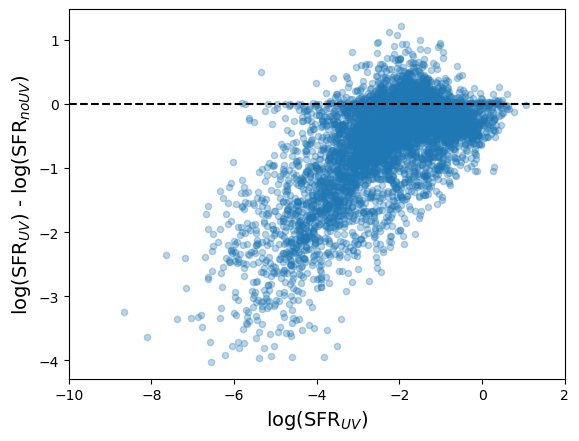

In [602]:
plt.scatter(sfr_uv,sfr_uv-sfr_nouv,s=20,alpha=0.3)
plt.axhline(0,color='black',ls='--')
plt.xlabel(r'log(SFR$_{UV}$)',fontsize=14)
plt.ylabel(r'log(SFR$_{UV}$) - log(SFR$_{no UV}$)',fontsize=14)
plt.xlim(-10,2)
plt.show()

#### Probability Distribution Functions

In [884]:
full_results_table = Table.read(homedir+'/Desktop/cigale_vf/out_negflux_with_PDFs/results.fits')

In [890]:
header_list = full_results_table.colnames

In [916]:
bands = ['FUV','NUV','WISE1','WISE2','WISE3','WISE4',
         'BASS-g','decamDR1-g','BASS-r','decamDR1-r','decamDR1-z']
bayes_list = [x for x in header_list if ('bayes' in x) & ('_err' not in x) & (x.replace('bayes.','') not in bands)]

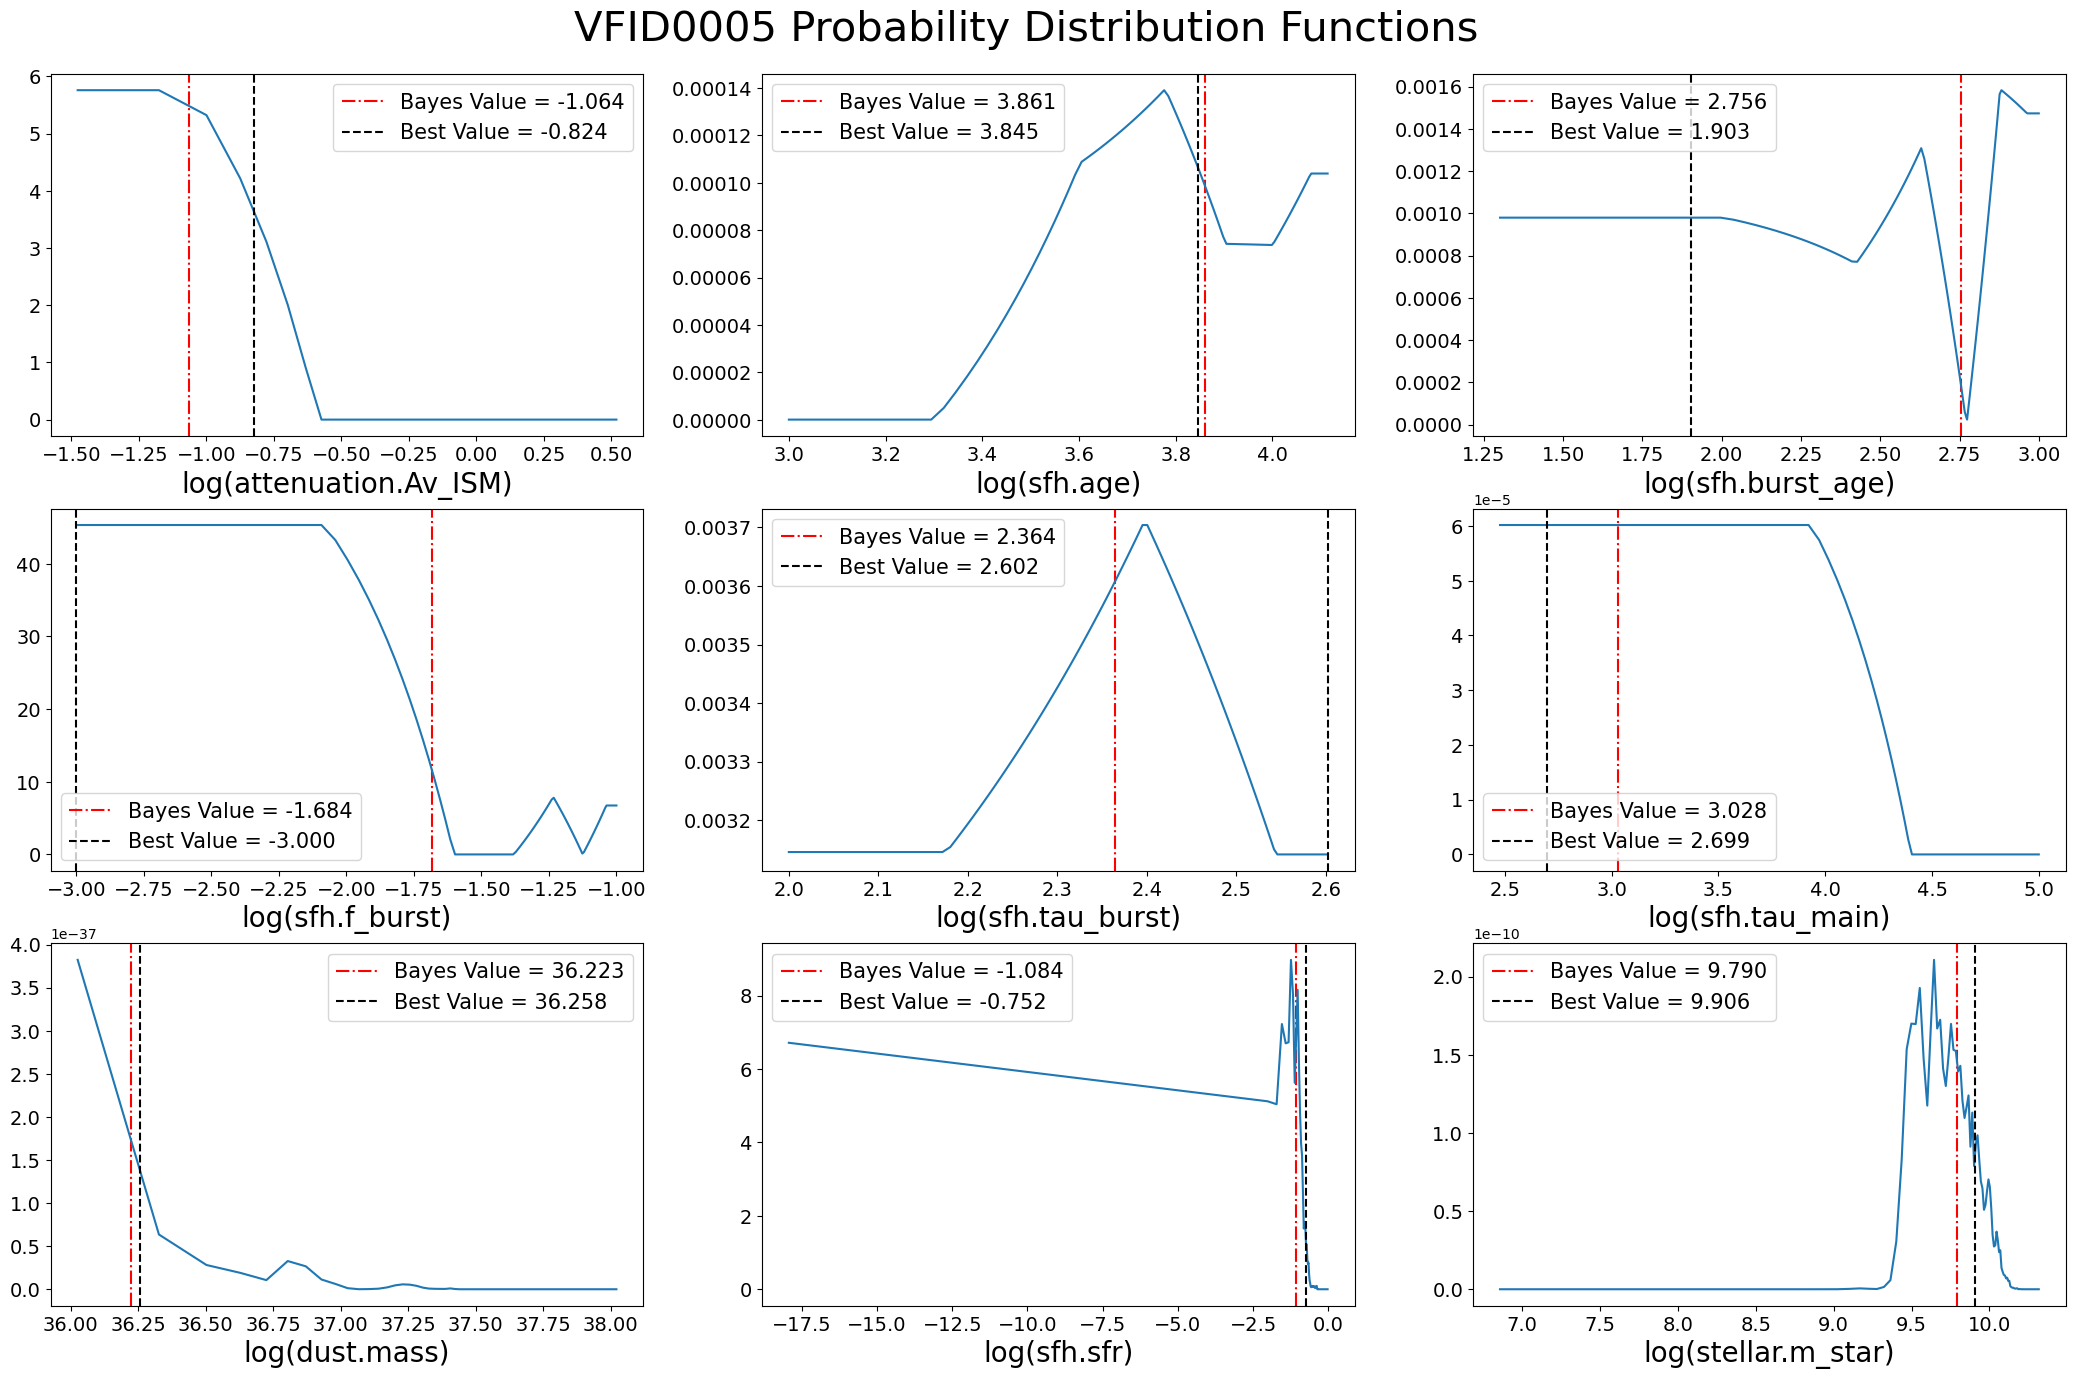

In [1006]:
import warnings
warnings.filterwarnings('ignore')

dir_path = homedir+'/Desktop/cigale_vf/out_negflux_with_PDFs/'

index=5

VFID = full_results_table['id'][index]

fig, ax = plt.subplots(3, 3,figsize=(26,16))
fig.suptitle(f'{VFID} Probability Distribution Functions',fontsize=30,y=0.92)
ax = ax.flatten()

for n, item in enumerate(bayes_list):
        
    ax[n].axvline(np.log10(full_results_table[item][index]),color='red',ls='-.',
                  label=f'Bayes Value = {np.log10(full_results_table[item][index]):.3f}')
    
    item = item.replace('bayes.','')
    prob_tab = Table.read(f'{dir_path}{VFID}_{item}.fits')
    
    ax[n].plot(np.log10(prob_tab[0][:]),prob_tab['probability'])
    
    best_value = np.log10(full_results_table['best.'+item][index])
    ax[n].axvline(np.log10(full_results_table['best.'+item][index]),color='black',ls='--',
                  label=f'Best Value = {best_value:.3f}')
    
    ax[n].set_xlabel(f'log({item})',fontsize=20)
    ax[n].tick_params(axis='both', labelsize=14)
    
    ax[n].legend(fontsize=15)

### scrap

In [1105]:
vfid6078_w3=fits.open(homedir+'/vf_html_w1_v2/all_input_fits/NGC4457-W3-fixBA-out2.fits')[2].data
vfid6078_w1=fits.open(homedir+'/vf_html_w1_v2/all_input_fits/NGC4457-W1-fixBA-out2.fits')[2].data

In [1106]:
hdu_w3 = fits.PrimaryHDU(vfid6078)
hdu_w3.writeto(homedir+'/Desktop/NGC4577_W3.fits',overwrite=True)

hdu_w1 = fits.PrimaryHDU(vfid6078)
hdu_w1.writeto(homedir+'/Desktop/NGC4577_W1.fits',overwrite=True)